# IMPORANCE MAP PREDICTION USING FCN-32 USING GDI DATASET

In [1]:
import tensorflow
import keras

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Training and Testing data Visualisation

1004_4721235550_b7c0ea7c33_z.png


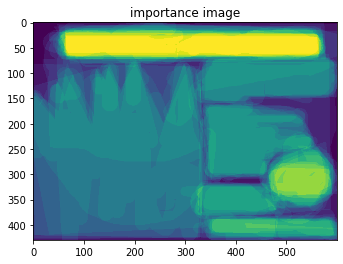

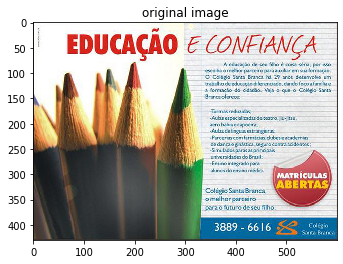

In [3]:
import random
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Path to the training and testing data
dir_data = "/content/drive/My Drive/HCI_prep/GDI/"

dir_seg_test = dir_data + "/gd_imp_val/"
dir_img_test = dir_data + "/gd_val/"
dir_seg_train = dir_data + "/gd_imp_train/"
dir_img_train = dir_data + "/gd_train/"

ldseg = np.array(os.listdir(dir_seg_train))
ldseg_tr = np.array(os.listdir(dir_img_train))

import matplotlib.image as mpimg

## pick the first image from training data
fnm = ldseg[0]
fnm_tr= ldseg_tr[0]

print(fnm)
img=mpimg.imread(dir_seg_train+fnm)
imgplot = plt.imshow(img)
plt.title("importance image")
plt.show()

img=mpimg.imread(dir_img_train+fnm_tr)
imgplot = plt.imshow(img)
plt.title("original image")
plt.show()


# Data Preprocessing

In [4]:
from PIL import Image

n_classes=1
meanval=(104.00699, 116.66877, 122.67892)

output_width, output_height= 224,224
input_width, input_height=224,224
def ImageArr(path, width, height):
    #print(path)
    img = cv2.imread(path, 1)
    #print(path)
    img = np.float32(cv2.resize(img, (width, height))) #/ 127.5 - 1
    #print(img.min())
    #print(img.max())
 
    # Meanvalue reduction
    img -= meanval
    #print(img.min())
    #print(img.max())
    #print("preprocessed image shape after meanval",img.shape)
    #print("preprocessed image array after meanval", img)
    #exit()
    return img


def ImpArr(path, classes, width, height):
    #print(path)
    
    seg_labels = np.zeros((height, width, classes))
    
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (width, height))
    img = img[:, :, 0]
    label = img/255.0
    #print(img.min())
    #print(img.max())
    #print("image array",img)
    #print("image shape",img.shape)
    for c in range(classes):
        seg_labels[:, :, c] = (img == c).astype(int)
    #print(seg_labels)
    return seg_labels
    '''
    # ACCORDIG TO THE REF PAPER
    img = cv2.imread(path, 1)
    img = cv2.resize(img, (width, height))
    label = np.array(img, dtype=np.uint8) # values range from 0 to 255
    label = label/255.0
    label = label[np.newaxis, ...]
    #print (label.shape)
    #print("Importance image",label)
    
    return seg_labels
    '''
images_train = os.listdir('/content/drive/My Drive/HCI_prep/GDI/gd_train')
images_train.sort()
print("sorted",images_train)

imp_train = os.listdir('/content/drive/My Drive/HCI_prep/GDI/gd_imp_train')
imp_train.sort()
print("sorted",imp_train )

images_test = os.listdir('/content/drive/My Drive/HCI_prep/GDI/gd_val')
images_test.sort()
print("sorted",images_train )

imp_test = os.listdir('/content/drive/My Drive/HCI_prep/GDI/gd_imp_val')
imp_test.sort()
print("sorted",imp_test )


X_train = []
X_test = []

Y_train = []
Y_test = []

for im, seg in zip(images_train, imp_train):
    X_train.append(ImageArr(dir_img_train + im, input_width, input_height))
    Y_train.append(ImpArr(dir_seg_train + seg, n_classes, output_width, output_height))

for im, seg in zip(images_test, imp_test):
    X_test.append(ImageArr(dir_img_test + im, input_width, input_height))
    Y_test.append(ImpArr(dir_seg_test + seg, n_classes, output_width, output_height))

X_tr, Y_tr = np.array(X_train), np.array(Y_train)
print(X_tr.shape, Y_tr.shape)


X_tst, Y_tst = np.array(X_test), np.array(Y_test)
print(X_tst.shape, Y_tst.shape)


sorted ['1004_4721235550_b7c0ea7c33_z.jpg', '1007_4609954933_516a10bdef_b.jpg', '1015_929552115_2891afc866_z.jpg', '1018_759693686_27724fd9b0_z.jpg', '1019_1332616268_7eb2f844f7_z.jpg', '102_313500921_3cf60858a4_b.jpg', '103_253886470_6bd567cd15_z.jpg', '1047_759183712_12070bee49_b.jpg', '104_274671051_c3f3c3d0ee_z.jpg', '104_286931284_4127cbd2f1_z.jpg', '1050_4726302921_1794cdba8e_z.jpg', '1056_648578924_7db2a20a5c_z.jpg', '1064_5120715603_3a7ac10322_b.jpg', '1067_4600212085_ab9c34df4d_z.jpg', '106_268082798_f833f668a2_z.jpg', '1070_5103878095_2cacd2e436_z.jpg', '1072_3169985933_4900cbf8ab_z.jpg', '1075_1403152938_36d34fbf6c_b.jpg', '1076_4720586951_3485f54f2c_z.jpg', '1078_5122373810_1c6efede04_b.jpg', '1081_5150994270_8c344bdb79_z.jpg', '1083_5103882264_7b28b184f1_z.jpg', '1087_5100985617_fbc6257e38_b.jpg', '1087_5150022176_85410ca4d4_z.jpg', '1088_5146389636_2cb2aa8765_z.jpg', '1103_5131374206_4d148c2eea_z.jpg', '1117_5125585658_a7c95b7b90_b.jpg', '1117_5160654701_eec818796c_z.jpg'

# FCN-32 model building

In [5]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
import keras, sys, time, warnings
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import pandas as pd

'''
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
config =  tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "2"
'''
set_session(tf.compat.v1.Session())

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

python 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
keras version 2.2.5
tensorflow version 1.15.0


In [0]:
import keras
from keras.models import *
from keras.layers import *

IMAGE_ORDERING = 'channels_last'

# take vgg-16 pretrained model from "https://github.com/fchollet/deep-learning-models" here
pretrained_url = "https://github.com/fchollet/deep-learning-models/" \
                     "releases/download/v0.1/" \
                     "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

pretrained= 'hello' #'imagenet' if weights need to be initialized!

def get_vgg_encoder(input_height=224,  input_width=224, pretrained=pretrained):
    pad = 1

    # heights and weights must be divided by 32, for fcn
    assert input_height % 32 == 0 
    assert input_width % 32 == 0

   
    img_input = Input(shape=(input_height, input_width, 3))

    # Unlike base paper, stride=1 has not been used here, because
    # Keras has default stride=1

    x = (ZeroPadding2D((pad, pad), data_format=IMAGE_ORDERING))(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='valid',name='block1_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',data_format=IMAGE_ORDERING)(x)
    f1 = x
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same',name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',data_format=IMAGE_ORDERING)(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same',name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',data_format=IMAGE_ORDERING)(x)
    f3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same',name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',data_format=IMAGE_ORDERING)(x)
    f4 = x

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same',name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',data_format=IMAGE_ORDERING)(x)
    f5 = x

    # Check if weights are initialised, model is learning!
    # Result: Model is not learning !!!
    # Henced set pretrained= hello
    if pretrained == 'imagenet':
        VGG_Weights_path = keras.utils.get_file(
            pretrained_url.split("/")[-1], pretrained_url)
        
        Model(img_input, x).load_weights(VGG_Weights_path)

    return img_input, [f1, f2, f3, f4, f5]

In [7]:
def fcn_32(n_classes, encoder=get_vgg_encoder, input_height=224,
           input_width=224):

    # Take levels from the base model, i.e. vgg
    img_input, levels = encoder(input_height=input_height,  input_width=input_width)
    [f1, f2, f3, f4, f5] = levels

    o = f5

    # fcn6
    o = (Conv2D(4096, (7, 7), activation='relu',padding='same', data_format=IMAGE_ORDERING))(o)
    o = Dropout(0.5)(o)

    #fc7
    o = (Conv2D(4096, (1, 1), activation='relu',padding='same', data_format=IMAGE_ORDERING))(o)
    o = Dropout(0.5)(o)

    #score_sal
    o = (Conv2D(n_classes,  (1, 1), kernel_initializer='he_normal',padding='same',data_format=IMAGE_ORDERING))(o)

    #upscore_sal
    o = Conv2DTranspose(n_classes, kernel_size=(64, 64),  strides=(32, 32), use_bias=False,  data_format=IMAGE_ORDERING)(o)

    #crop layer
    ## Caffe calls crop layer that takes o and img_input as argument, it takes their difference and crops
    ## But keras takes it as touple, I checked the size diff and put this value manually.
    ## output dim was 256 , input dim was 224. 256-224=32. so 32/2=16
    score= Cropping2D(cropping=((16,16), (16, 16)),data_format=IMAGE_ORDERING)(o)

    o = (Activation('linear'))(score)
    model = Model(img_input, o)
    
    model.model_name = "fcn_32"
    
    return model

model = fcn_32(n_classes=1, encoder=get_vgg_encoder, input_height=224,
           input_width=224)
model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
____

# Training with Early-stopping

In [8]:
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

#sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

sgd = optimizers.SGD(lr=1E-3, momentum=0.90,decay=5**(-4), nesterov=True)

# Here I changed loss to 'mse',and also 'kullback_leibler_divergence'. But nothing is changing.
model.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['accuracy'])

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

hist1 = model.fit(X_tr,Y_tr,validation_data=(X_tst,Y_tst),batch_size=16,epochs=1000,verbose=0, callbacks=[es, mc])

model.save("/content/drive/My Drive/HCI_prep/new_without_weights_gdi_1000_epochs.h5")


# evaluate the model
saved_model = load_model("/content/drive/My Drive/HCI_prep/new_without_weights_gdi_1000_epochs.h5")

_, train_acc = saved_model.evaluate(X_tr,Y_tr, verbose=0)
_, test_acc = saved_model.evaluate(X_tst,Y_tst, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where









/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


Epoch 00099: early stopping
Train: 0.800, Test: 0.781


# Visualizing the model performance

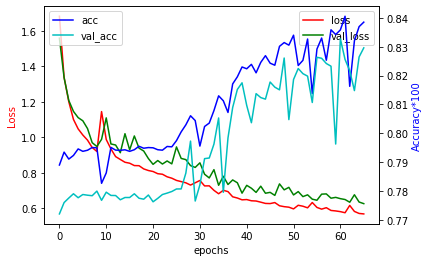

In [13]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
c=0
col= ["r","g","b","c"]
for key1 in ['loss', 'val_loss']:
    #print(hist1.history[key1])
    ax1.plot(hist1.history[key1][:66],label=key1, c=col[c])
    ax1.legend()
    c=c+1
for key2 in ['acc', 'val_acc']:
    ax2.plot(hist1.history[key2][:66],label=key2, c=col[c])
    ax2.legend()
    c=c+1


ax1.set_xlabel('epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Accuracy*100', color='b')
plt.savefig("/content/drive/My Drive//HCI_prep/loss_acc_fcn_32_gdi_1000_epochs_20_12_2019")